In [ ]:
from google.colab import files
upload = files.upload()

Saving preprocessed.csv to preprocessed (1).csv


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('/content/preprocessed.csv')
df.columns = ['index', 'tweet','label']
df

,index,tweet,label
0,0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,1,lokasi strategis di jalan sumatera bandung te...,positive
2,2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,3,duh jadi mahasiswa jangan sombong dong kasih...,negative
4,4,makan agam harga makan di food stall akan tam...,positive
...,...,...,...
10994,10994,tidak kecewa,positive
10995,10995,enak rasa masakan nya apalagi kepiting yang se...,positive
10996,10996,hormat partai yang telah koalisi,neutral
10997,10997,pagi pagi di tol pasteur sudah macet parah bi...,negative


In [ ]:
df.drop('index', axis=1)

,tweet,label
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,lokasi strategis di jalan sumatera bandung te...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh jadi mahasiswa jangan sombong dong kasih...,negative
4,makan agam harga makan di food stall akan tam...,positive
...,...,...
10994,tidak kecewa,positive
10995,enak rasa masakan nya apalagi kepiting yang se...,positive
10996,hormat partai yang telah koalisi,neutral
10997,pagi pagi di tol pasteur sudah macet parah bi...,negative


In [ ]:
df['tweet'] = df['tweet'].astype(str)

In [ ]:
def cleaning(tweet):
  
  string = tweet.lower()
  string = re.sub(r'[^a-zA-Z]+', ' ', string)
  string = re.sub('0-9', ' ', string)
  
  return string
df['tweet'] = df['tweet'].apply(cleaning)

In [ ]:
!pip install sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
reader = df['tweet']
factory = StopWordRemoverFactory()
stopwords = factory.create_stop_word_remover()
df['tweet'] = df['tweet'].apply(stopwords.remove)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pd.Series(" ".join(reader).split()).value_counts(10)

nya          0.054973
makan        0.026477
enak         0.015093
tempat       0.014644
rasa         0.010139
               ...   
sangking     0.000004
berhati      0.000004
diler        0.000004
kedalemmm    0.000004
foodlife     0.000004
Length: 12754, dtype: float64

In [ ]:
df.tweet.duplicated().sum()

200

In [ ]:
df['tweet'] = df.tweet.drop_duplicates()

In [ ]:
df.label.value_counts()

positive    6415
negative    3436
neutral     1148
Name: label, dtype: int64

In [ ]:
tweet = df.tweet.to_list()

In [ ]:
#import library model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#TFIDF

In [ ]:
df['tweet'] = df['tweet'].astype(str)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df['tweet'])

X = tfidf_vectorizer.transform(df['tweet'])
y = df['label']

In [ ]:
pickle.dump(tfidf_vectorizer, open('feature.p', 'wb'))

In [ ]:
import joblib
joblib.dump(tfidf_vectorizer, open('feature.pkl', 'wb'))

In [ ]:
X

<10999x12730 sparse matrix of type '<class 'numpy.float64'>'
	with 211496 stored elements in Compressed Sparse Row format>

In [ ]:
y

0         neutral
1        positive
2        positive
3        negative
4        positive
           ...   
10994    positive
10995    positive
10996     neutral
10997    negative
10998    positive
Name: label, Length: 10999, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

#Model NN SKLearn

In [ ]:
model = MLPClassifier()
model_nn = model.fit(X_train, y_train)

In [ ]:
import joblib
joblib.dump(model_nn, 'mlpc.pkl')

['mlpc.pkl']

In [ ]:
history = model.predict(X_test)
print(classification_report(y_test, history))

              precision    recall  f1-score   support

    negative       0.74      0.73      0.74       687
     neutral       0.75      0.67      0.71       230
    positive       0.87      0.89      0.88      1283

    accuracy                           0.82      2200
   macro avg       0.79      0.76      0.77      2200
weighted avg       0.81      0.82      0.82      2200



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


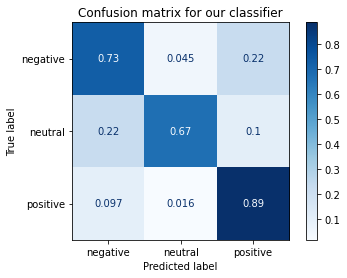

In [ ]:
#generate confusion matrix
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show();

In [ ]:
#evaluasi
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []
y = y

for iteration, data in enumerate(kf.split(X), start=1):
  data_train = X[data[0]]
  target_train = y[data[0]]

  data_test = X[data[1]]
  target_test = y[data[1]]

  clf = MLPClassifier()
  clf.fit(data_train, target_train)

  preds = clf.predict(data_test)

  accuracy = accuracy_score(target_test, preds)

  print('training ke-', iteration)
  print(classification_report(target_test, preds))
  print('-------------------------------------------')

  accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('rata-rata akurasi:', average_accuracy)

training ke- 1
              precision    recall  f1-score   support

    negative       0.74      0.76      0.75       693
     neutral       0.70      0.69      0.70       213
    positive       0.87      0.86      0.87      1294

    accuracy                           0.81      2200
   macro avg       0.77      0.77      0.77      2200
weighted avg       0.82      0.81      0.82      2200

-------------------------------------------
training ke- 2
              precision    recall  f1-score   support

    negative       0.78      0.75      0.76       729
     neutral       0.79      0.63      0.70       247
    positive       0.84      0.90      0.87      1224

    accuracy                           0.82      2200
   macro avg       0.80      0.76      0.78      2200
weighted avg       0.81      0.82      0.81      2200

-------------------------------------------
training ke- 3
              precision    recall  f1-score   support

    negative       0.75      0.76      0.76       

#Trial Prediction Input

In [ ]:
text = """
makanannya enak banget!!!
"""
teks = tfidf_vectorizer.transform([cleaning(text)])

result = model.predict(teks)[0]
print('sentiment', result)

sentiment positive
